## Assignment 06

#### Submitted By:
1. Dhruvan Ganesh
2. Sheikh Mastura Farzana

In [1]:
%load_ext tensorboard

### Environment Information
---

In [2]:
import torch.cuda
from pytorch_lightning import seed_everything
from torch import device

device = device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))

seed = 42
seed_everything(seed)
print("Set Random Seed:", seed)

data_dir = "~/.datasets"
print("Data Dir:", data_dir)

Device: cuda:0
Device Name: GeForce GTX 1660 Ti
Set Random Seed: 42
Data Dir: ~/.datasets


### Assignment6 (End of July)
---

- Write a Variational Convolutional AutoEncoder on CFAR10 + Add denoising to the model
- Use the latent space for CFAR10 classification
- Write Adam optimizer in pytorch (without using nn.Adam!)
- Extra point: What is a Pixel shuffle? and How can you use it in PyTorch?
- Extra point: to do your previous assignment on latent space of CAE for robot classification


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_kwargs(**kwargs):
    return kwargs

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.show()

## <span style="font-variant:small-caps">Task 1: Variational Convolutional AutoEncoder on CIFAR10 + Denoising</span>
---

In [4]:
import torch
from pytorch_lightning import LightningModule

import torch.nn as nn

In [5]:
class ConvolutionalEncoder(nn.Module):
    @staticmethod
    def _conv_block(
        in_channels, out_channels, kernel_size, stride=1, padding=0, batch_norm=True
    ):
        block = [
            nn.Conv2d(
                in_channels, out_channels, kernel_size, padding=padding, stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ]
        if not batch_norm:
            block = block[:-1]
        return block

    def __init__(self, batch_size, color_channels):
        super(ConvolutionalEncoder, self).__init__()

        self.batch_size = batch_size
        self.layer1 = nn.Sequential(
            *self._conv_block(color_channels, 32, 3, padding=1),
            *self._conv_block(32, 32, 3, padding=1),
            *self._conv_block(32, 64, 3, padding=1),
            *self._conv_block(64, 64, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )
        self.layer2 = nn.Sequential(
            *self._conv_block(64, 128, 3, padding=1),
            *self._conv_block(128, 128, 3, padding=1),
            nn.MaxPool2d(2, 2),
            *self._conv_block(128, 256, 3, padding=1, batch_norm=False),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(self.batch_size, -1)
        return out

In [6]:
class ConvolutionalDecoder(nn.Module):
    @staticmethod
    def _conv_t_block(
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        output_padding=0,
        batch_norm=True,
    ):
        block = [
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                padding=padding,
                stride=stride,
                output_padding=output_padding,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ]
        if not batch_norm:
            block = block[:-1]
        return block

    def __init__(self, batch_size, color_channels):
        super(ConvolutionalDecoder, self).__init__()

        self.batch_size = batch_size
        self.layer1 = nn.Sequential(
            *self._conv_t_block(256, 128, 3, 2, 1, 1),
            *self._conv_t_block(128, 128, 3, 1, 1),
            *self._conv_t_block(128, 64, 3, 1, 1),
            *self._conv_t_block(64, 64, 3, 1, 1),
        )
        self.layer2 = nn.Sequential(
            *self._conv_t_block(64, 32, 3, 1, 1),
            *self._conv_t_block(32, 32, 3, 1, 1),
            *self._conv_t_block(32, color_channels, 3, 2, 1, 1, batch_norm=False),
        )

    def forward(self, x):
        out = x.view(self.batch_size, 256, 8, 8)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [7]:
class ConvolutionalAutoEncoder(LightningModule):
    def __init__(self, batch_size, color_channels):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = ConvolutionalEncoder(
            batch_size=batch_size, color_channels=color_channels
        )
        self.decoder = ConvolutionalDecoder(
            batch_size=batch_size, color_channels=color_channels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


class Cifar10Module(LightningModule):
    def __init__(self, batch_size):
        super(Cifar10Module, self).__init__()
        self.batch_size = batch_size
        self.preprocess = transforms.Compose([transforms.ToTensor(),])
        self.classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        )
        self.color_channels = 3

    def train_dataloader(self):
        dataset = datasets.CIFAR10(
            data_dir, train=True, download=True, transform=self.preprocess
        )
        loader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=8,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
        )
        return loader

    def val_dataloader(self):
        dataset = datasets.CIFAR10(
            data_dir, train=False, download=True, transform=self.preprocess
        )
        loader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=8,
            pin_memory=True,
            drop_last=True,
        )
        return loader

In [9]:
from torchvision import utils


def make_grid(tensors=(), idxs=()):
    out_tensors = []
    for tensor in tensors:
        for idx in idxs:
            out_tensors.append(tensor[idx])
    return out_tensors


class DenoisingCAECifar10(Cifar10Module):
    def __init__(self, batch_size):
        super(DenoisingCAECifar10, self).__init__(batch_size=batch_size)
        self.batch_size = batch_size
        self.model = ConvolutionalAutoEncoder(batch_size, self.color_channels)
        self.loss = nn.MSELoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)
        return [optimizer], [scheduler]

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        x_n = torch.mul(x + 0.25, 0.1 * torch.rand(x.size()).to(self.device))
        out = self(x_n)
        loss = self.loss(out, x)
        tensorboard_logs = {"reconstruction_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        x_n = torch.mul(x + 0.25, 0.1 * torch.rand(x.size()).to(self.device))
        out = self(x_n)

        if batch_nb == 0 and self.current_epoch % 2 == 1:
            print(f"\nEpoch {self.current_epoch}:\n---------")
            grid_imgs = torch.stack(
                make_grid(
                    tensors=[x.detach(), x_n.detach(), out.detach(),], idxs=(0, 15, 16)
                ),
            )
            show(
                utils.make_grid(
                    grid_imgs, nrow=grid_imgs.size()[0] // 3, normalize=True,
                ).cpu()
            )

        return {"val_loss": self.loss(out, x)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_reconstruction_loss": avg_loss.item()}
        return {"val_loss": avg_loss, "log": tensorboard_logs}

In [10]:
from os import path

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger


def train_model_or_load_checkpoint(
    model_clazz: LightningModule,
    checkpoint_path: str,
    max_epochs: int,
    tensorboard_graph_name: str,
    device=device,
    **model_params
):
    if path.exists(checkpoint_path):
        print("Found pre-trained model!\nLoading Model...")
        model = model_clazz.load_from_checkpoint(checkpoint_path, **model_params)
        model = model.to(device)
        print("Loaded Model")
        return model
    else:
        model = model_clazz(**model_params)
        print("Begin Training...")
        logger = TensorBoardLogger("lightning_logs", name=tensorboard_graph_name)
        trainer = Trainer(
            checkpoint_callback=False,
            logger=logger,
            gpus=1,
            num_nodes=1,
            deterministic=True,
            max_epochs=max_epochs,
            progress_bar_refresh_rate=0,
            progress_bar_callback=False
        )
        trainer.fit(model)
        print("Training Complete")
        if "invalid" not in checkpoint_path:
            trainer.save_checkpoint(checkpoint_path)
            print("Saving Checkpoint")
        return model

In [37]:
%tensorboard --logdir lightning_logs/cae/deconv_denoised_cae

Reusing TensorBoard on port 6006 (pid 48581), started 1:15:33 ago. (Use '!kill 48581' to kill it.)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Begin Training...



   | Name                    | Type                     | Params
-----------------------------------------------------------------
0  | model                   | ConvolutionalAutoEncoder | 1 M   
1  | model.encoder           | ConvolutionalEncoder     | 583 K 
2  | model.encoder.layer1    | Sequential               | 65 K  
3  | model.encoder.layer1.0  | Conv2d                   | 896   
4  | model.encoder.layer1.1  | ReLU                     | 0     
5  | model.encoder.layer1.2  | BatchNorm2d              | 64    
6  | model.encoder.layer1.3  | Conv2d                   | 9 K   
7  | model.encoder.layer1.4  | ReLU                     | 0     
8  | model.encoder.layer1.5  | BatchNorm2d              | 64    
9  | model.encoder.layer1.6  | Conv2d                   | 18 K  
10 | model.encoder.layer1.7  | ReLU                     | 0     
11 | model.encoder.layer1.8  | BatchNorm2d              | 128   
12 | model.encoder.layer1.9  | Conv2d                   | 36 K  
13 | model.encoder.laye

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Epoch 1:
---------


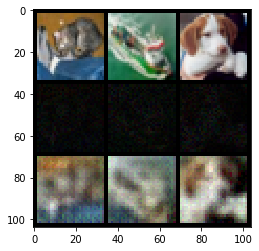


Epoch 3:
---------


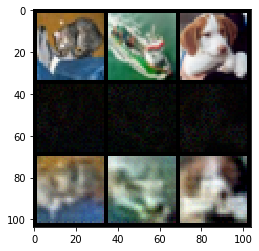


Epoch 5:
---------


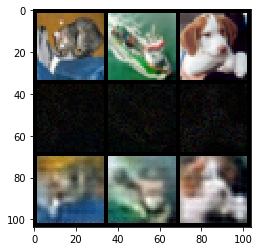


Epoch 7:
---------


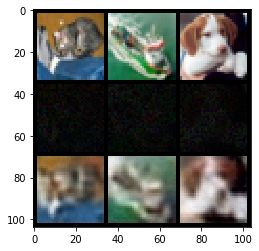


Epoch 9:
---------


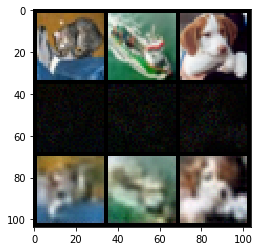


Epoch 11:
---------


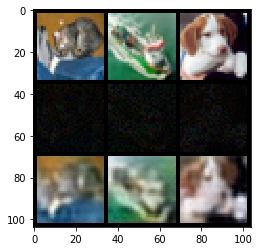


Epoch 13:
---------


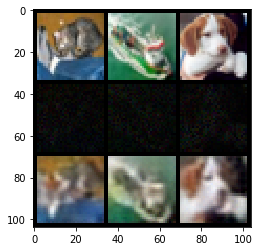


Epoch 15:
---------


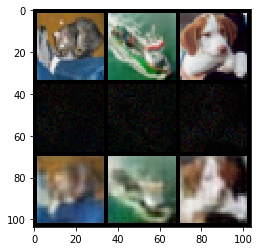


Epoch 17:
---------


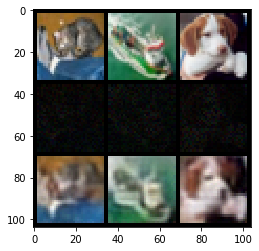


Epoch 19:
---------


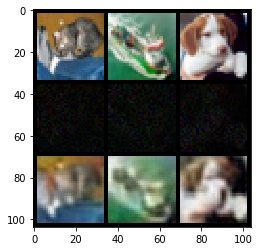

Training Complete
Saving Checkpoint


/home/navrudh/Apps/miniconda3/envs/cudavision/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


In [12]:
model_params = get_kwargs(batch_size=256)

cifar_model = train_model_or_load_checkpoint(
    model_clazz=DenoisingCAECifar10,
    checkpoint_path="dcae_c10.ckpt",
    max_epochs=20,
    tensorboard_graph_name="cae/deconv_denoised_cae",
    batch_size=256
)

## <span style="font-variant:small-caps">Task 2: Use the latent space for CIFAR10 classification</span>
---

In [13]:
class LatentSpaceClassifierCifar10(Cifar10Module):
    def __init__(self, batch_size, latent_space_encoder):
        super().__init__(batch_size=batch_size)
        self.batch_size = batch_size
        self.model = torch.nn.Sequential(
            nn.Linear(256 * 8 * 8, 84), nn.Dropout(0.2), nn.Linear(84, 10)
        )
        self.latent_space_encoder = latent_space_encoder.to(device)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.latent_space_encoder(x)
        return self.model(x.view(x.size(0), -1))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        labels_hat = torch.argmax(y_hat, dim=1)
        train_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)
        tensorboard_logs = {"train_loss": loss.item(), "train_acc": train_acc}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        labels_hat = torch.argmax(y_hat, dim=1)
        val_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)

        return {"val_loss": self.loss(y_hat, y), "val_acc": torch.tensor(val_acc)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss, "val_acc": avg_acc}
        return {"val_loss": avg_loss, "val_acc": avg_acc, "log": tensorboard_logs}

    @torch.no_grad()
    def get_all_preds(self):
        all_preds = torch.tensor([]).to(device)
        labels = torch.tensor([], dtype=torch.int64).to(device)
        for x, y in self.val_dataloader():
            x, y = x.to(device), y.to(device)
            y_hat = self.forward(x)
            all_preds = torch.cat((all_preds, y_hat), dim=0)
            labels = torch.cat((labels, y), dim=0)
        pred_labels = all_preds.argmax(dim=1)
        return pred_labels, labels

In [22]:
model_params = get_kwargs(batch_size=256)

cifar_model = train_model_or_load_checkpoint(
    model_clazz=DenoisingCAECifar10,
    checkpoint_path="dcae_c10.ckpt",
    max_epochs=20,
    tensorboard_graph_name="cae/deconv_denoised_cae",
    batch_size=256
)

Found pre-trained model!
Loading Model...
Loaded Model


In [38]:
%tensorboard --logdir lightning_logs/classification/latent_space_classifier

In [24]:
model_params = get_kwargs(
    batch_size=256, latent_space_encoder=cifar_model.model.encoder
)

latent_space_classifier_model = train_model_or_load_checkpoint(
    model_clazz=LatentSpaceClassifierCifar10,
    checkpoint_path="latent_space_classifier_c10.ckpt",
    max_epochs=20,
    tensorboard_graph_name="classification/latent_space_classifier",
    **model_params
)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type                 | Params
--------------------------------------------------------------------
0  | model                          | Sequential           | 1 M   
1  | model.0                        | Linear               | 1 M   
2  | model.1                        | Dropout              | 0     
3  | model.2                        | Linear               | 850   
4  | latent_space_encoder           | ConvolutionalEncoder | 583 K 
5  | latent_space_encoder.layer1    | Sequential           | 65 K  
6  | latent_space_encoder.layer1.0  | Conv2d               | 896   
7  | latent_space_encoder.layer1.1  | ReLU                 | 0     
8  | latent_space_encoder.layer1.2  | BatchNorm2d          | 64    
9  | latent_space_encoder.layer1.3  | Conv2d               | 9 K   
10 | latent_space_encoder.layer1.4  | ReLU                 | 0     

Begin Training...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training Complete
Saving Checkpoint


In [25]:
from sklearn.metrics import classification_report

y_pred, y_true = latent_space_classifier_model.get_all_preds()
y_pred, y_true = y_pred.cpu().numpy(), y_true.cpu().numpy()


print("\n==================\nValidation Report:\n==================")
print(
    classification_report(
        y_true, y_pred, target_names=latent_space_classifier_model.classes
    )
)

latent_space_classifier_model = None

Files already downloaded and verified

Validation Report:
              precision    recall  f1-score   support

       plane       0.85      0.86      0.86       998
         car       0.91      0.93      0.92       999
        bird       0.78      0.77      0.77       999
         cat       0.71      0.71      0.71       997
        deer       0.81      0.82      0.82      1000
         dog       0.78      0.76      0.77       997
        frog       0.87      0.88      0.88      1000
       horse       0.88      0.87      0.87       997
        ship       0.91      0.91      0.91       997
       truck       0.92      0.89      0.90      1000

    accuracy                           0.84      9984
   macro avg       0.84      0.84      0.84      9984
weighted avg       0.84      0.84      0.84      9984



## <span style="font-variant:small-caps">Task 3: Write Adam optimizer in pytorch (without using nn.Adam!)</span>
---

In [26]:
from torch.optim.optimizer import Optimizer


class AdamFromScratch(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(AdamFromScratch, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    state["first_moment"] = 0
                    state["second_moment"] = 0

                state["step"] += 1

                beta1 = group["beta1"]
                beta2 = group["beta2"]

                state["first_moment"] = (
                    beta1 * state["first_moment"] + (1 - beta1) * grad
                )
                state["second_moment"] = (
                    beta2 * state["second_moment"] + (1 - beta2) * grad * grad
                )

                first_unbias = state["first_moment"] / (1 - self.beta1 ** state["step"])
                second_unbias = state["second_moment"] / (
                    1 - self.beta2 ** state["step"]
                )

                p.sub_(
                    first_unbias / (second_unbias.sqrt().add_(group["eps"])),
                    alpha=group["lr"],
                )

        return loss

In [27]:
class LatentSpaceClassifierAdamFromScratch(LatentSpaceClassifierCifar10):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def configure_optimizers(self):
        optimizer = AdamFromScratch(self.parameters(), lr=0.001)
        return optimizer

### We substitute the Latent Space Classifier with out implementation and compare both results

In [39]:
%tensorboard --logdir lightning_logs/classification

In [29]:
model_params = get_kwargs(
    batch_size=256, latent_space_encoder=cifar_model.model.encoder
)

adam_from_scratch_test = train_model_or_load_checkpoint(
    model_clazz=LatentSpaceClassifierAdamFromScratch,
    checkpoint_path="adam_from_scratch_test.ckpt",
    max_epochs=20,
    tensorboard_graph_name="classification/adam_from_scratch",
    **model_params
)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type                 | Params
--------------------------------------------------------------------
0  | model                          | Sequential           | 1 M   
1  | model.0                        | Linear               | 1 M   
2  | model.1                        | Dropout              | 0     
3  | model.2                        | Linear               | 850   
4  | latent_space_encoder           | ConvolutionalEncoder | 583 K 
5  | latent_space_encoder.layer1    | Sequential           | 65 K  
6  | latent_space_encoder.layer1.0  | Conv2d               | 896   
7  | latent_space_encoder.layer1.1  | ReLU                 | 0     
8  | latent_space_encoder.layer1.2  | BatchNorm2d          | 64    
9  | latent_space_encoder.layer1.3  | Conv2d               | 9 K   
10 | latent_space_encoder.layer1.4  | ReLU                 | 0     

Begin Training...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training Complete
Saving Checkpoint


In [30]:
from sklearn.metrics import classification_report

y_pred, y_true = adam_from_scratch_test.get_all_preds()
y_pred, y_true = y_pred.cpu().numpy(), y_true.cpu().numpy()


print("\n==================\nValidation Report:\n==================")
print(
    classification_report(
        y_true, y_pred, target_names=adam_from_scratch_test.classes
    )
)

adam_from_scratch_test = None

Files already downloaded and verified

Validation Report:
              precision    recall  f1-score   support

       plane       0.81      0.88      0.84       998
         car       0.90      0.94      0.92       999
        bird       0.82      0.73      0.77       999
         cat       0.69      0.67      0.68       997
        deer       0.75      0.82      0.79      1000
         dog       0.74      0.75      0.75       997
        frog       0.89      0.82      0.85      1000
       horse       0.81      0.88      0.84       997
        ship       0.92      0.89      0.90       997
       truck       0.92      0.87      0.89      1000

    accuracy                           0.82      9984
   macro avg       0.83      0.82      0.82      9984
weighted avg       0.83      0.82      0.82      9984



In [31]:
cifar_model = None

## <span style="font-variant:small-caps">Task 4: What is a Pixel shuffle? and How can you use it in PyTorch?</span>
---

PixelShuffle is an upsampling technique that is computationally more efficient and preserves more
information than Deconvolution.

>We observe this by substituting the `ConvolutionalDecoder` with the `PixelShuffleDecoder`.
Notice that tensorboard graphs report similar loss values and the `PixelShuffleDecoder` is much faster (can be observed in the `Relative` field in TB).

In [32]:
torch.cuda.empty_cache()

In [33]:
class PixelShuffleDecoder(nn.Module):
    @staticmethod
    def _pb_block(
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        px_r=2,
    ):
        return [
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                padding=padding,
            ),
            nn.ReLU(),
            nn.PixelShuffle(px_r),
        ]

    def __init__(self, batch_size, color_channels):
        super(PixelShuffleDecoder, self).__init__()

        self.batch_size = batch_size
        self.layer1 = nn.Sequential(
            *self._pb_block(256, 32*4, 3, 1, px_r=2),
        )
        self.layer2 = nn.Sequential(
            *self._pb_block(32, color_channels*4, 3, 1, px_r=2),
        )

    def forward(self, x):
        out = x.view(self.batch_size, 256, 8, 8)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [34]:
class SPDenoisingCAECifar10(DenoisingCAECifar10):
    def __init__(self, batch_size):
        super(SPDenoisingCAECifar10, self).__init__(batch_size)
        self.model.decoder = PixelShuffleDecoder(batch_size, self.color_channels)

### PixelShuffle (sub_pixel_denoised_cae) vs Deconvolution (deconv_denoised_cae)

In [40]:
%tensorboard --logdir lightning_logs/cae

In [ ]:
model_params = get_kwargs(batch_size=256)

sp_denoised_cae_model = train_model_or_load_checkpoint(
    model_clazz=SPDenoisingCAECifar10,
    checkpoint_path="sub_px_denoised_cae_model.ckpt",
    max_epochs=20,
    tensorboard_graph_name="cae/sub_pixel_denoised_cae",
    **model_params
)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type                     | Params
-----------------------------------------------------------------
0  | model                   | ConvolutionalAutoEncoder | 881 K 
1  | model.encoder           | ConvolutionalEncoder     | 583 K 
2  | model.encoder.layer1    | Sequential               | 65 K  
3  | model.encoder.layer1.0  | Conv2d                   | 896   
4  | model.encoder.layer1.1  | ReLU                     | 0     
5  | model.encoder.layer1.2  | BatchNorm2d              | 64    
6  | model.encoder.layer1.3  | Conv2d                   | 9 K   
7  | model.encoder.layer1.4  | ReLU                     | 0     
8  | model.encoder.layer1.5  | BatchNorm2d              | 64    
9  | model.encoder.layer1.6  | Conv2d                   | 18 K  
10 | model.encoder.layer1.7  | ReLU                     | 0     
11 | model.encoder.layer1.8  | BatchNo

Begin Training...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

Epoch 1:
---------


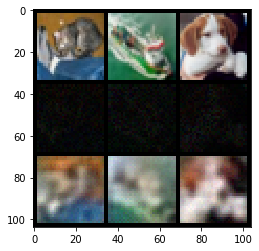


Epoch 3:
---------


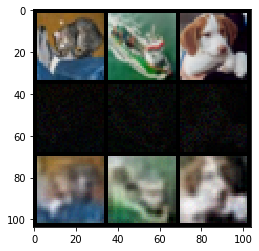


Epoch 5:
---------


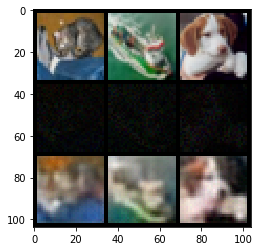


Epoch 7:
---------


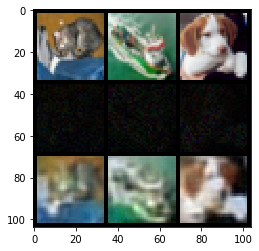


Epoch 9:
---------


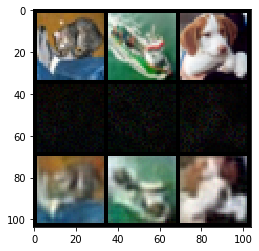


Epoch 11:
---------


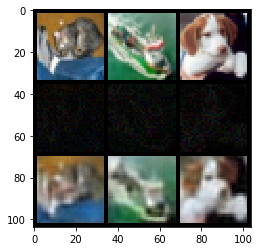


Epoch 13:
---------


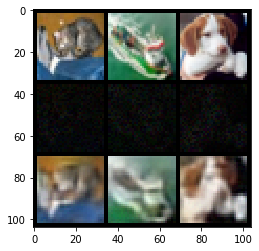


Epoch 15:
---------


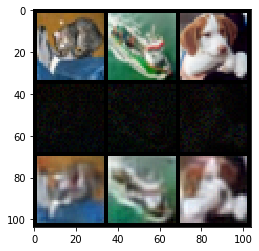


Epoch 17:
---------


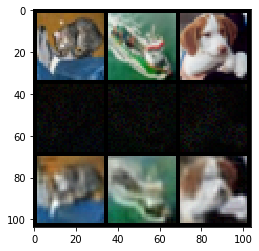


Epoch 19:
---------


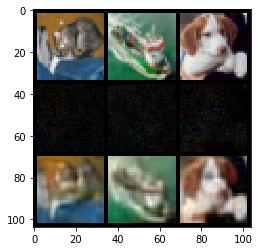

Training Complete
Saving Checkpoint


In [36]:
## <span style="font-variant:small-caps">Task 5: In `assignment-05-cae-latent-space.ipynb` file</span>
---

## <span style="font-variant:small-caps">Task 5: In `assignment-05-cae-latent-space.ipynb` file</span>
---